In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sql 

In [6]:
from sqlalchemy import create_engine
driver = 'mysql+pymysql:'
user = 'alvaro'
password = 'stalvaro19962013'
ip = '35.246.28.129'
database = 'data_crunch'
connection_string = f'{driver}//{user}:{password}@{ip}/{database}?charset=utf8'
engine = create_engine(connection_string)

In [8]:
companies = pd.read_sql_table(table_name='companies15', con=connection_string)
investments = pd.read_sql_table(table_name='investments15', con=connection_string)
people = pd.read_sql_table(table_name='people', con=connection_string)
rounds = pd.read_sql_table(table_name='rounds15', con=connection_string)

## Getting info from the company

In [2]:
name = input('Name of the company: ')

Name of the company: Facebook


In [3]:
sector = input('In what sector is this company working: ')

In what sector is this company working: Social Media


In [4]:
founder = input('What is the name of the founder: ')

What is the name of the founderMark Zuckerberg


## Looking for info on Crunchbase

In [40]:
def category(sector):    
    # Prepare the data for the sector
    sector_investments = investments[investments['company_category_list']==sector].drop('index',axis=1)
    sector_investments.reset_index(drop=True)
    sector_investments['funded_at'] = pd.to_datetime(sector_investments['funded_at'])
    sector_investments['Year'] = sector_investments['funded_at'].apply(lambda x: x.year )
    sector_investments['Month'] = sector_investments['funded_at'].apply(lambda x: x.month )
    sector_investments['Day'] = sector_investments['funded_at'].apply(lambda x: x.day )
    # create plot
    sector_year = sector_investments.groupby(['Year']).sum()[-10:]
    return sns.lineplot(x=sector_year.index, y=sector_year.raised_amount_usd)

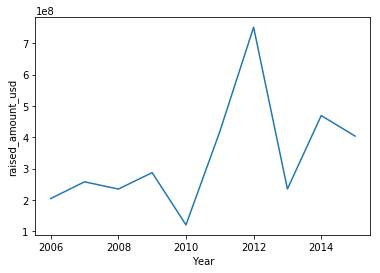

In [41]:
category(sector)